# **Testing Models**

**Author:** Arnav Singh 
**Date:** 2024-11-17

---

## **Abstract**

For this notebook, we will use the OMNI and OCB data from the dayside and Nightside files to explore which edited data works the best with a whole bunch of Regression Models, optimzing to get the lowest RMSE.

In [12]:
### Imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    KFold, 
    GridSearchCV,
    learning_curve  # Added this import
)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_error
)
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import xgboost as xgb
import shap
from scipy import stats

In [13]:
### Main Code ###
def create_nn_regressor(input_shape):
    """Create a robust neural network regressor with regularization"""
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        
        layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        layers.Dense(128, kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        
        layers.Dense(64, kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.1),
        
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def evaluate_regression_model(y_true, y_pred, model_name):
    """Calculate comprehensive regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate adjusted R-squared
    n = len(y_true)
    p = 1  # number of predictors (update this based on your model)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Adjusted_R2': adj_r2
    }

def plot_residuals(y_true, y_pred, model_name):
    """Create comprehensive residual plots"""
    residuals = y_true - y_pred
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Residuals vs Predicted
    axes[0,0].scatter(y_pred, residuals, alpha=0.5)
    axes[0,0].axhline(y=0, color='r', linestyle='--')
    axes[0,0].set_xlabel('Predicted Values')
    axes[0,0].set_ylabel('Residuals')
    axes[0,0].set_title('Residuals vs Predicted')
    
    # Residual Distribution
    sns.histplot(residuals, kde=True, ax=axes[0,1])
    axes[0,1].set_title('Residual Distribution')
    
    # Q-Q Plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot')
    
    # Scale-Location Plot
    axes[1,1].scatter(y_pred, np.sqrt(np.abs(residuals)), alpha=0.5)
    axes[1,1].set_xlabel('Predicted Values')
    axes[1,1].set_ylabel('√|Residuals|')
    axes[1,1].set_title('Scale-Location Plot')
    
    plt.suptitle(f'Residual Diagnostics - {model_name}', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_feature_importance_regression(model, feature_names, model_name, X_test, y_test):
    """Plot feature importance using multiple methods"""
    plt.figure(figsize=(12, 6))
    
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        importances = model.feature_importances_
        importance_type = "Native Feature Importance"
    else:
        # For other models, use permutation importance
        result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        importances = result.importances_mean
        importance_type = "Permutation Importance"
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    
    # Plot feature importances
    sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices])
    plt.title(f'{model_name} - {importance_type}')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

def plot_learning_curves_regression(model, X_train, y_train, cv=5):
    """Plot learning curves with confidence intervals"""
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train,
        train_sizes=train_sizes,
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Score')
    plt.fill_between(train_sizes, 
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, 
                    alpha=0.1)
    plt.plot(train_sizes, val_scores_mean, label='Cross-validation Score')
    plt.fill_between(train_sizes,
                    val_scores_mean - val_scores_std,
                    val_scores_mean + val_scores_std,
                    alpha=0.1)
    
    plt.xlabel('Training Examples')
    plt.ylabel('MSE')
    plt.title(f'Learning Curves - {type(model).__name__}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def train_regression_models(df, features, target, test_size=0.2):
    """Train and evaluate multiple regression models with advanced techniques"""
    # Prepare data
    X = df[features]
    y = df[target]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)
    
    # Initialize models with parameter grids
    models = {
        'Linear': {
            'model': LinearRegression(),
            'params': {},
            'poly': False
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.1, 1.0, 10.0],
                'solver': ['auto', 'svd', 'cholesky']
            },
            'poly': True
        },
        'Lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [0.1, 1.0, 10.0],
                'selection': ['cyclic', 'random']
            },
            'poly': True
        },
        'ElasticNet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.1, 1.0, 10.0],
                'l1_ratio': [0.2, 0.5, 0.8]
            },
            'poly': True
        },
        'RandomForest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5]
            },
            'poly': False
        },
        'GradientBoosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.1],
                'max_depth': [3, 5]
            },
            'poly': False
        },
        'XGBoost': {
            'model': xgb.XGBRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.1],
                'max_depth': [3, 5],
                'min_child_weight': [1, 3]
            },
            'poly': False
        }
    }
    
    results = []
    trained_models = {}
    
    # Train and evaluate each model
    for name, config in models.items():
        print(f"\nTraining {name}...")
        
        # Choose appropriate feature set
        X_train_final = X_train_poly if config['poly'] else X_train_scaled
        X_test_final = X_test_poly if config['poly'] else X_test_scaled
        
        # Perform grid search with cross-validation
        if config['params']:
            grid_search = GridSearchCV(
                config['model'],
                config['params'],
                cv=5,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )
            grid_search.fit(X_train_final, y_train)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for {name}: {grid_search.best_params_}")
        else:
            best_model = config['model']
            best_model.fit(X_train_final, y_train)
        
        # Store trained model
        trained_models[name] = best_model
        
        # Make predictions
        y_pred = best_model.predict(X_test_final)
        
        # Evaluate model
        metrics = evaluate_regression_model(y_test, y_pred, name)
        results.append(metrics)
        
        # Plot residuals
        plot_residuals(y_test, y_pred, name)
        
        # Plot feature importance
        if name not in ['Linear', 'Ridge', 'Lasso', 'ElasticNet']:
            plot_feature_importance_regression(
                best_model, features, name, X_test_final, y_test
            )
        
        # Plot learning curves
        plot_learning_curves_regression(best_model, X_train_final, y_train)
        
        # For the best performing model, generate SHAP values
        if name in ['RandomForest', 'GradientBoosting', 'XGBoost']:
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_test_final)
            
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values, X_test_final, feature_names=features)
            plt.title(f'SHAP Values - {name}')
            plt.show()
    
    # Train Neural Network
    print("\nTraining Neural Network...")
    nn_model = create_nn_regressor((X_train_scaled.shape[1],))
    
    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )
    
    # Train neural network
    history = nn_model.fit(
        X_train_scaled,
        y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Evaluate neural network
    y_pred_nn = nn_model.predict(X_test_scaled).flatten()
    nn_metrics = evaluate_regression_model(y_test, y_pred_nn, "Neural Network")
    results.append(nn_metrics)
    trained_models["Neural Network"] = nn_model
    
    # Plot neural network training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Convert results to DataFrame and plot model comparisons
    results_df = pd.DataFrame(results)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.barplot(x='Model', y='RMSE', data=results_df)
    plt.xticks(rotation=45)
    plt.title('RMSE Comparison')
    
    plt.subplot(1, 3, 2)
    sns.barplot(x='Model', y='MAE', data=results_df)
    plt.xticks(rotation=45)
    plt.title('MAE Comparison')
    
    plt.subplot(1, 3, 3)
    sns.barplot(x='Model', y='R2', data=results_df)
    plt.xticks(rotation=45)
    plt.title('R² Score Comparison')
    
    plt.tight_layout()
    plt.show()
    
    return results_df, trained_models

def plot_prediction_vs_actual(y_test, y_pred, model_name):
    """Create scatter plot of predicted vs actual values with regression line"""
    plt.figure(figsize=(10, 6))
    
    # Scatter plot
    plt.scatter(y_test, y_pred, alpha=0.5)
    
    # Add regression line
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), "r--", alpha=0.8)
    
    # Add perfect prediction line
    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs Actual Values - {model_name}')
    
    # Add R² value to plot
    r2 = r2_score(y_test, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.3f}', 
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_partial_dependence(model, X, features, feature_names, model_name):
    """Plot partial dependence plots for each feature"""
    n_features = len(features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.ravel()
    
    for idx, feature in enumerate(features):
        # Create feature grid
        feature_values = np.linspace(X[feature].min(), X[feature].max(), 50)
        predictions = []
        
        # Generate predictions for each feature value
        for value in feature_values:
            X_temp = X.copy()
            X_temp[feature] = value
            pred = model.predict(X_temp)
            predictions.append(np.mean(pred))
        
        # Plot partial dependence
        axes[idx].plot(feature_values, predictions)
        axes[idx].set_xlabel(feature_names[idx])
        axes[idx].set_ylabel('Partial dependence')
        axes[idx].grid(True)
    
    # Remove empty subplots
    for idx in range(len(features), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle(f'Partial Dependence Plots - {model_name}')
    plt.tight_layout()
    plt.show()

def analyze_feature_correlations(df, features, target):
    """Analyze and visualize feature correlations"""
    # Calculate correlation matrix
    corr_matrix = df[features + [target]].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Plot pairwise relationships
    sns.pairplot(df[features + [target]], diag_kind='kde')
    plt.suptitle('Pairwise Feature Relationships', y=1.02)
    plt.show()

def create_ensemble_prediction(models, X_test, weights=None):
    """Create ensemble prediction from multiple models"""
    predictions = []
    
    for name, model in models.items():
        if isinstance(model, tf.keras.Sequential):
            pred = model.predict(X_test).flatten()
        else:
            pred = model.predict(X_test)
        predictions.append(pred)
    
    predictions = np.array(predictions)
    
    if weights is None:
        # Simple averaging
        ensemble_pred = np.mean(predictions, axis=0)
    else:
        # Weighted averaging
        ensemble_pred = np.average(predictions, axis=0, weights=weights)
    
    return ensemble_pred

def plot_prediction_intervals(y_test, y_pred, model_name, confidence=0.95):
    """Plot prediction intervals using bootstrapping"""
    from scipy import stats
    
    # Calculate residuals
    residuals = y_test - y_pred
    
    # Calculate prediction interval
    std_resid = np.std(residuals)
    z_score = stats.norm.ppf((1 + confidence) / 2)
    margin = z_score * std_resid
    
    # Sort for plotting
    sort_idx = np.argsort(y_pred)
    y_pred_sorted = y_pred[sort_idx]
    y_test_sorted = y_test[sort_idx]
    
    plt.figure(figsize=(10, 6))
    
    # Plot actual vs predicted
    plt.scatter(y_pred_sorted, y_test_sorted, alpha=0.5, label='Actual vs Predicted')
    
    # Plot prediction intervals
    plt.fill_between(y_pred_sorted,
                    y_pred_sorted - margin,
                    y_pred_sorted + margin,
                    alpha=0.2,
                    label=f'{confidence*100}% Prediction Interval')
    
    plt.plot([y_pred_sorted.min(), y_pred_sorted.max()],
             [y_pred_sorted.min(), y_pred_sorted.max()],
             'k--', label='Perfect Prediction')
    
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(f'Prediction Intervals - {model_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

def analyze_prediction_errors(y_test, y_pred, X_test, features, model_name):
    """Analyze prediction errors in detail"""
    # Calculate errors
    errors = y_test - y_pred
    abs_errors = np.abs(errors)
    
    plt.figure(figsize=(15, 10))
    
    # Error distribution
    plt.subplot(2, 2, 1)
    sns.histplot(errors, kde=True)
    plt.title('Error Distribution')
    plt.xlabel('Prediction Error')
    
    # Error vs Predicted
    plt.subplot(2, 2, 2)
    plt.scatter(y_pred, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Error')
    plt.title('Error vs Predicted Values')
    
    # Feature vs Error plots
    error_correlations = []
    for feature in features:
        correlation = np.corrcoef(X_test[feature], errors)[0, 1]
        error_correlations.append((feature, abs(correlation)))
    
    # Plot top 2 most correlated features vs errors
    top_features = sorted(error_correlations, key=lambda x: x[1], reverse=True)[:2]
    
    for i, (feature, corr) in enumerate(top_features):
        plt.subplot(2, 2, i + 3)
        plt.scatter(X_test[feature], errors, alpha=0.5)
        plt.xlabel(feature)
        plt.ylabel('Error')
        plt.title(f'Error vs {feature} (corr={corr:.3f})')
    
    plt.suptitle(f'Prediction Error Analysis - {model_name}')
    plt.tight_layout()
    plt.show()

def calculate_prediction_metrics(y_test, y_pred):
    """Calculate detailed prediction metrics"""
    metrics = {
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'Mean Error': np.mean(y_test - y_pred),
        'Error Std': np.std(y_test - y_pred),
        'MAPE': np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    }
    
    return pd.Series(metrics)

def cross_validate_with_statistics(model, X, y, cv=5):
    """Perform cross-validation with statistical analysis"""
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    mse_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    mae_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    
    # Calculate statistics
    stats = {
        'R² Mean': cv_scores.mean(),
        'R² Std': cv_scores.std(),
        'MSE Mean': mse_scores.mean(),
        'MSE Std': mse_scores.std(),
        'RMSE Mean': np.sqrt(mse_scores).mean(),
        'RMSE Std': np.sqrt(mse_scores).std(),
        'MAE Mean': mae_scores.mean(),
        'MAE Std': mae_scores.std()
    }
    
    return pd.Series(stats)

# Add this to the main training function
def predict_with_uncertainty(trained_models, X_test, n_iterations=100):
    """Generate predictions with uncertainty estimates using bootstrap aggregating"""
    all_predictions = []
    
    for _ in range(n_iterations):
        # Randomly sample models with replacement
        selected_models = np.random.choice(list(trained_models.values()), 
                                         size=len(trained_models), 
                                         replace=True)
        
        # Generate predictions
        iteration_predictions = []
        for model in selected_models:
            if isinstance(model, tf.keras.Sequential):
                pred = model.predict(X_test).flatten()
            else:
                pred = model.predict(X_test)
            iteration_predictions.append(pred)
        
        # Average predictions for this iteration
        avg_prediction = np.mean(iteration_predictions, axis=0)
        all_predictions.append(avg_prediction)
    
    # Calculate mean and confidence intervals
    predictions = np.array(all_predictions)
    mean_prediction = np.mean(predictions, axis=0)
    lower_bound = np.percentile(predictions, 2.5, axis=0)
    upper_bound = np.percentile(predictions, 97.5, axis=0)
    
    return mean_prediction, lower_bound, upper_bound

### Actual Usage of Models

Analyzing Nightside Data...

Analyzing Nightside Hemisphere Data...

Analyzing feature correlations...


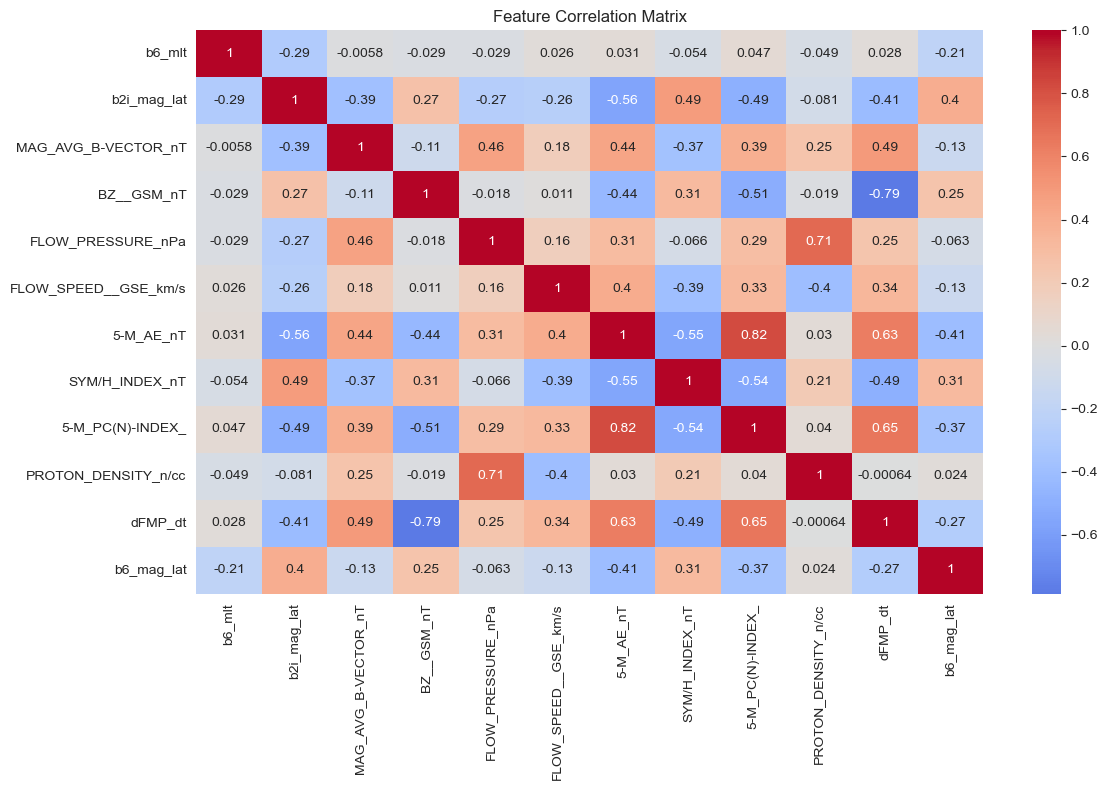

/Users/beastxgamer/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


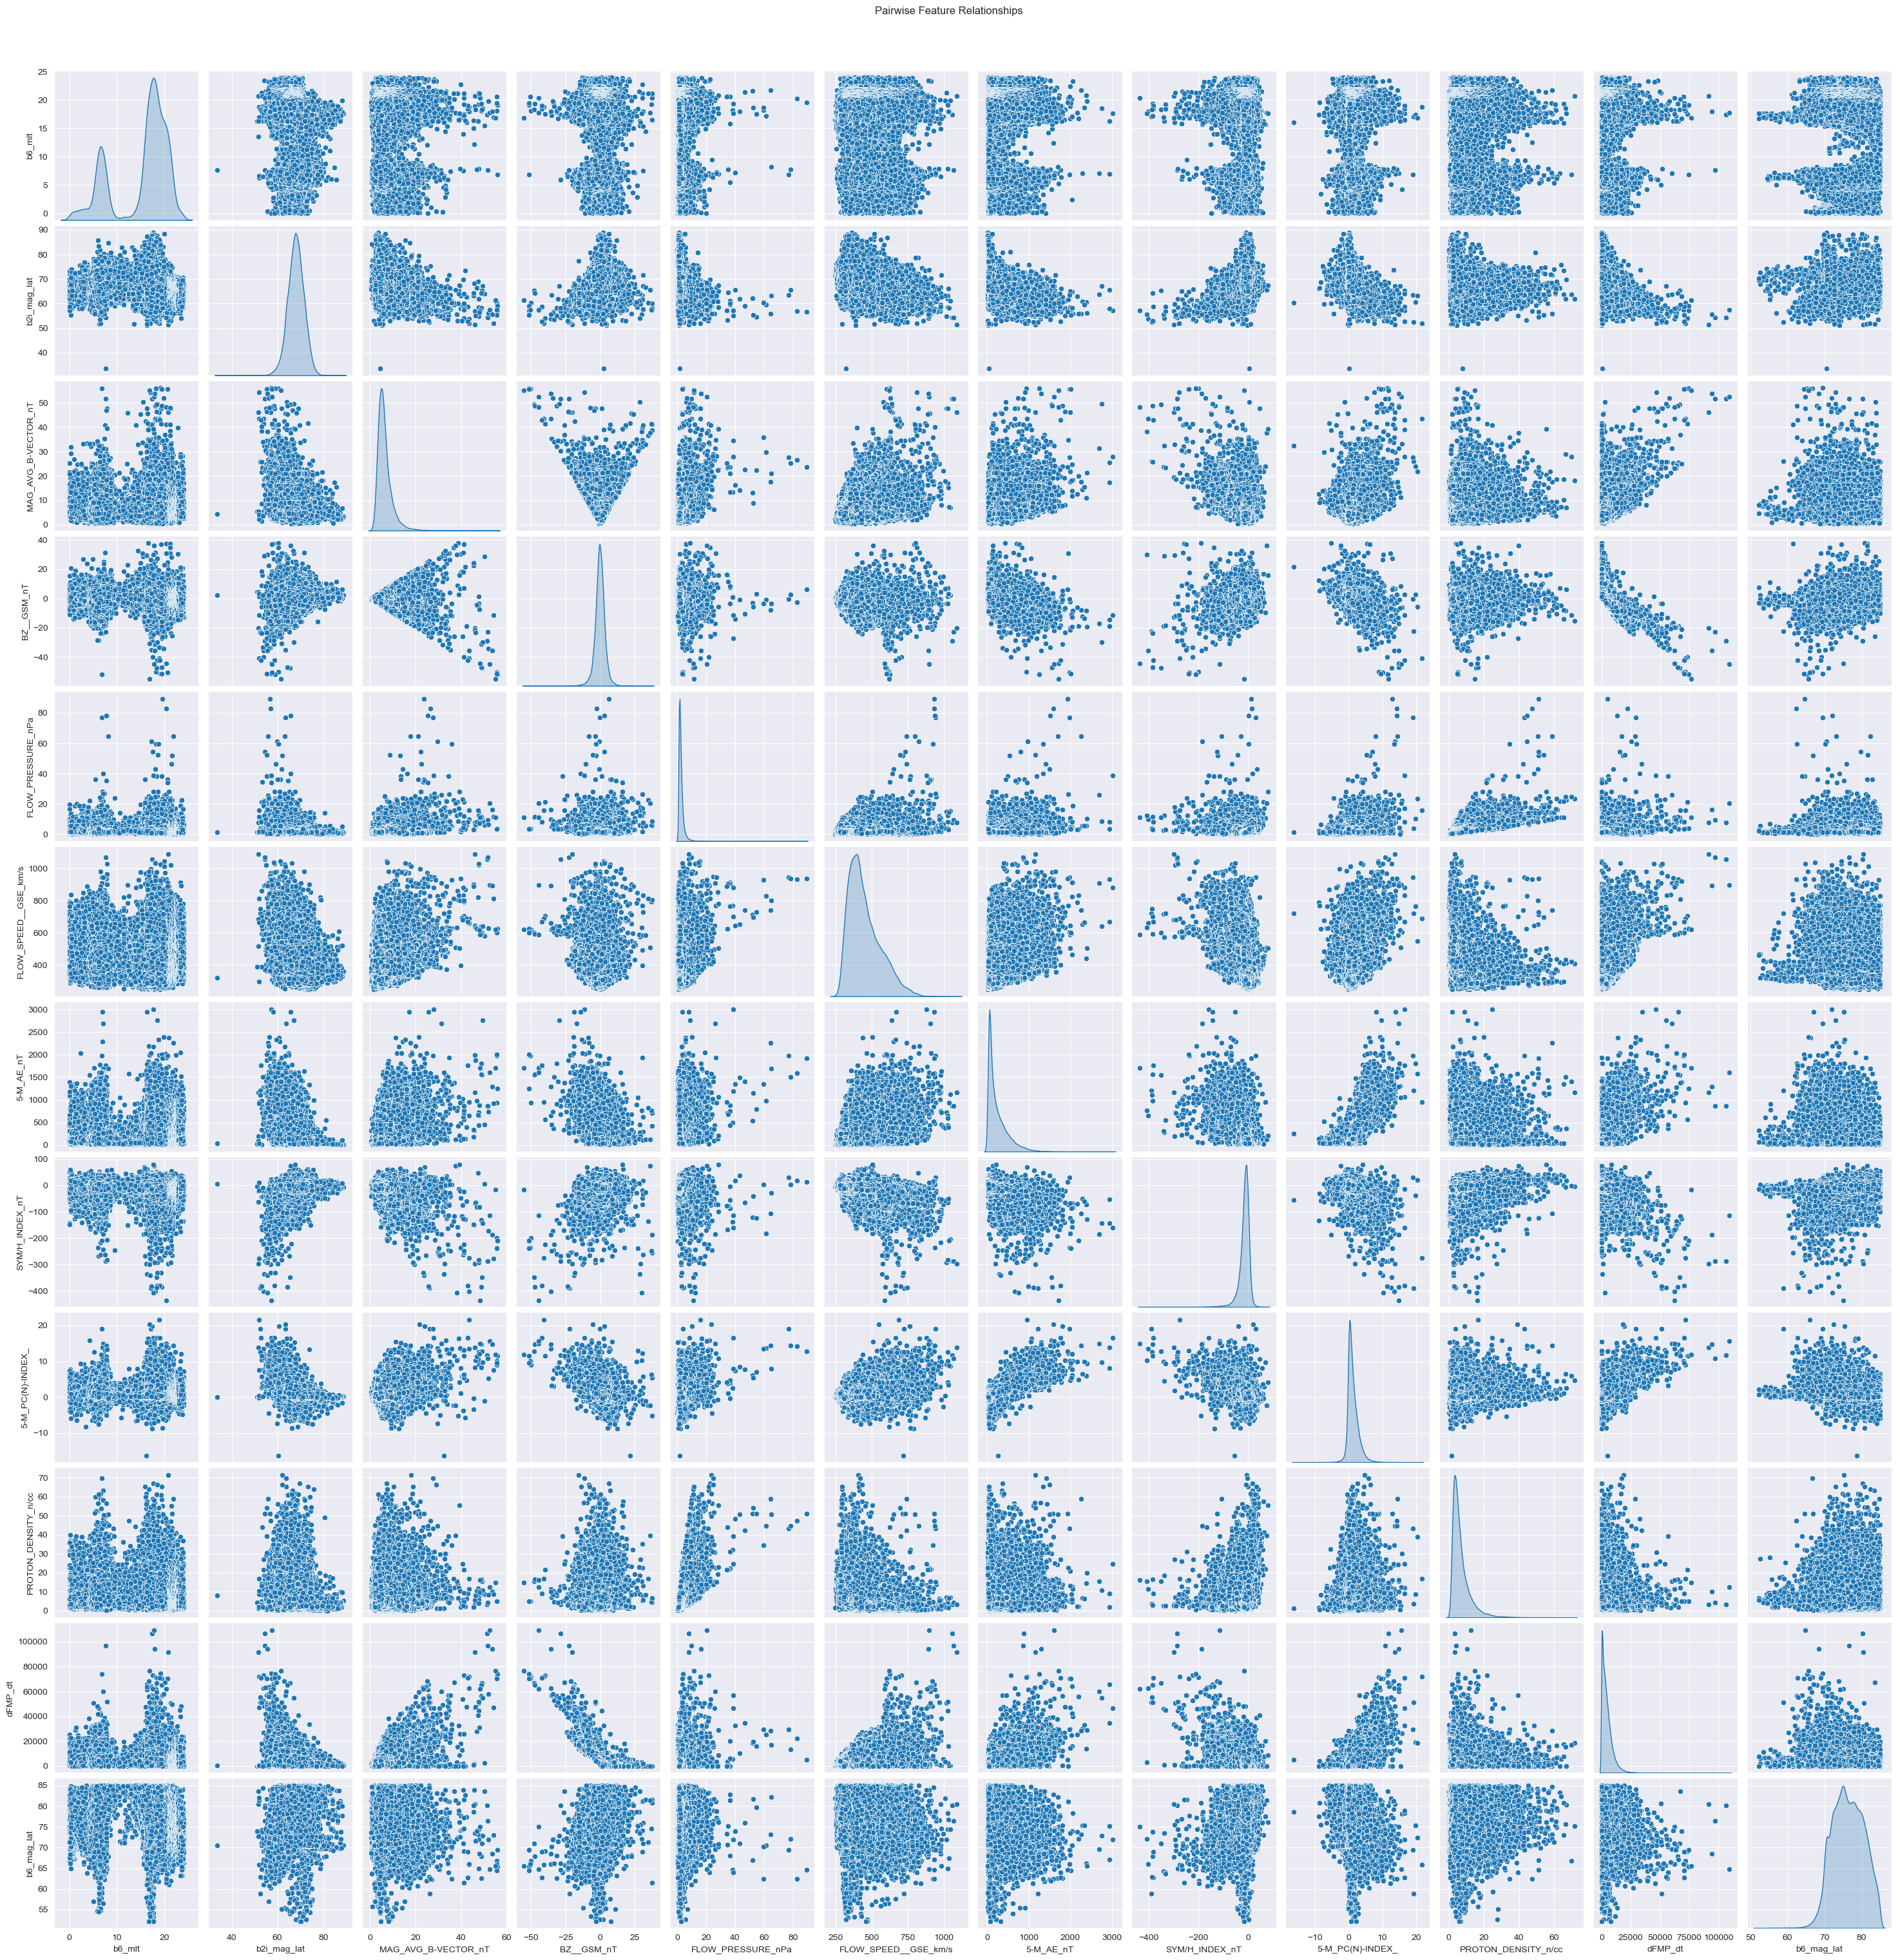


Training Nightside Northern Hemisphere Models...

Training Linear...


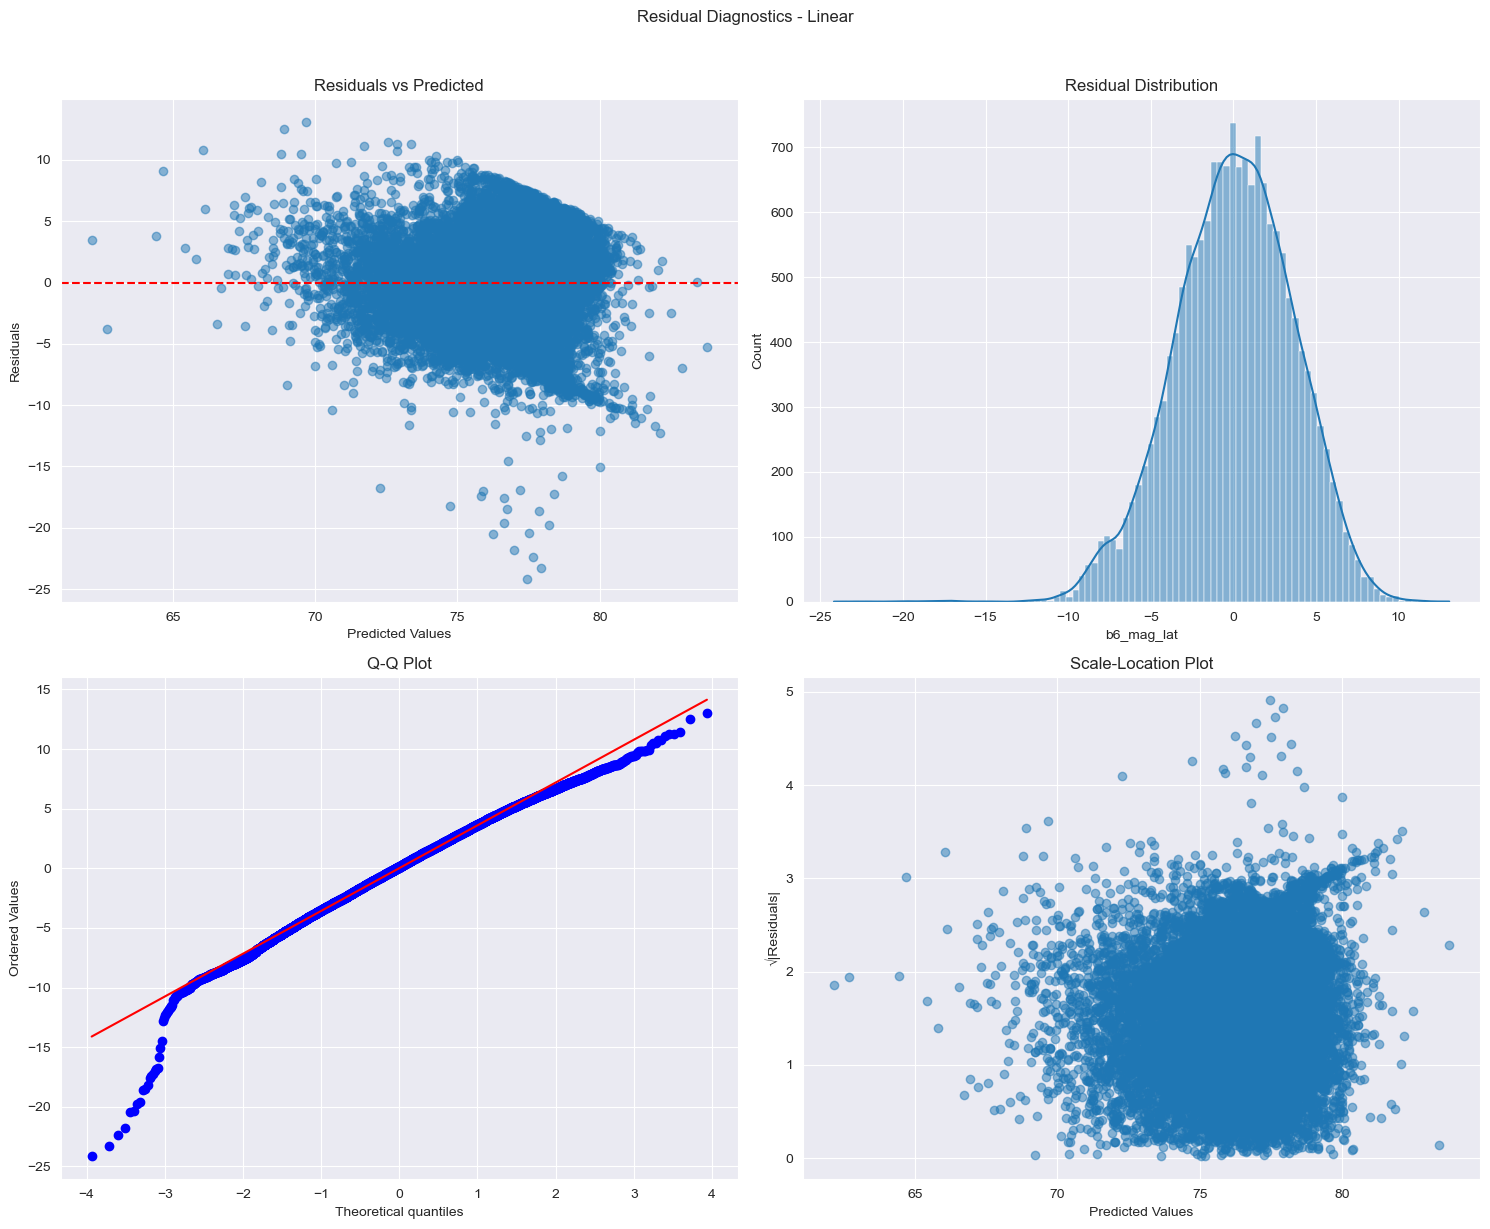

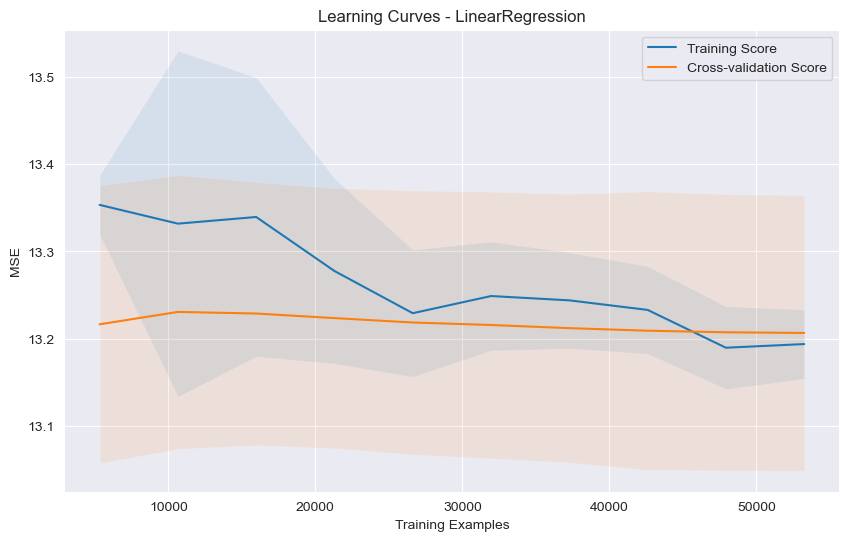


Training Ridge...
Best parameters for Ridge: {'alpha': 0.1, 'solver': 'svd'}


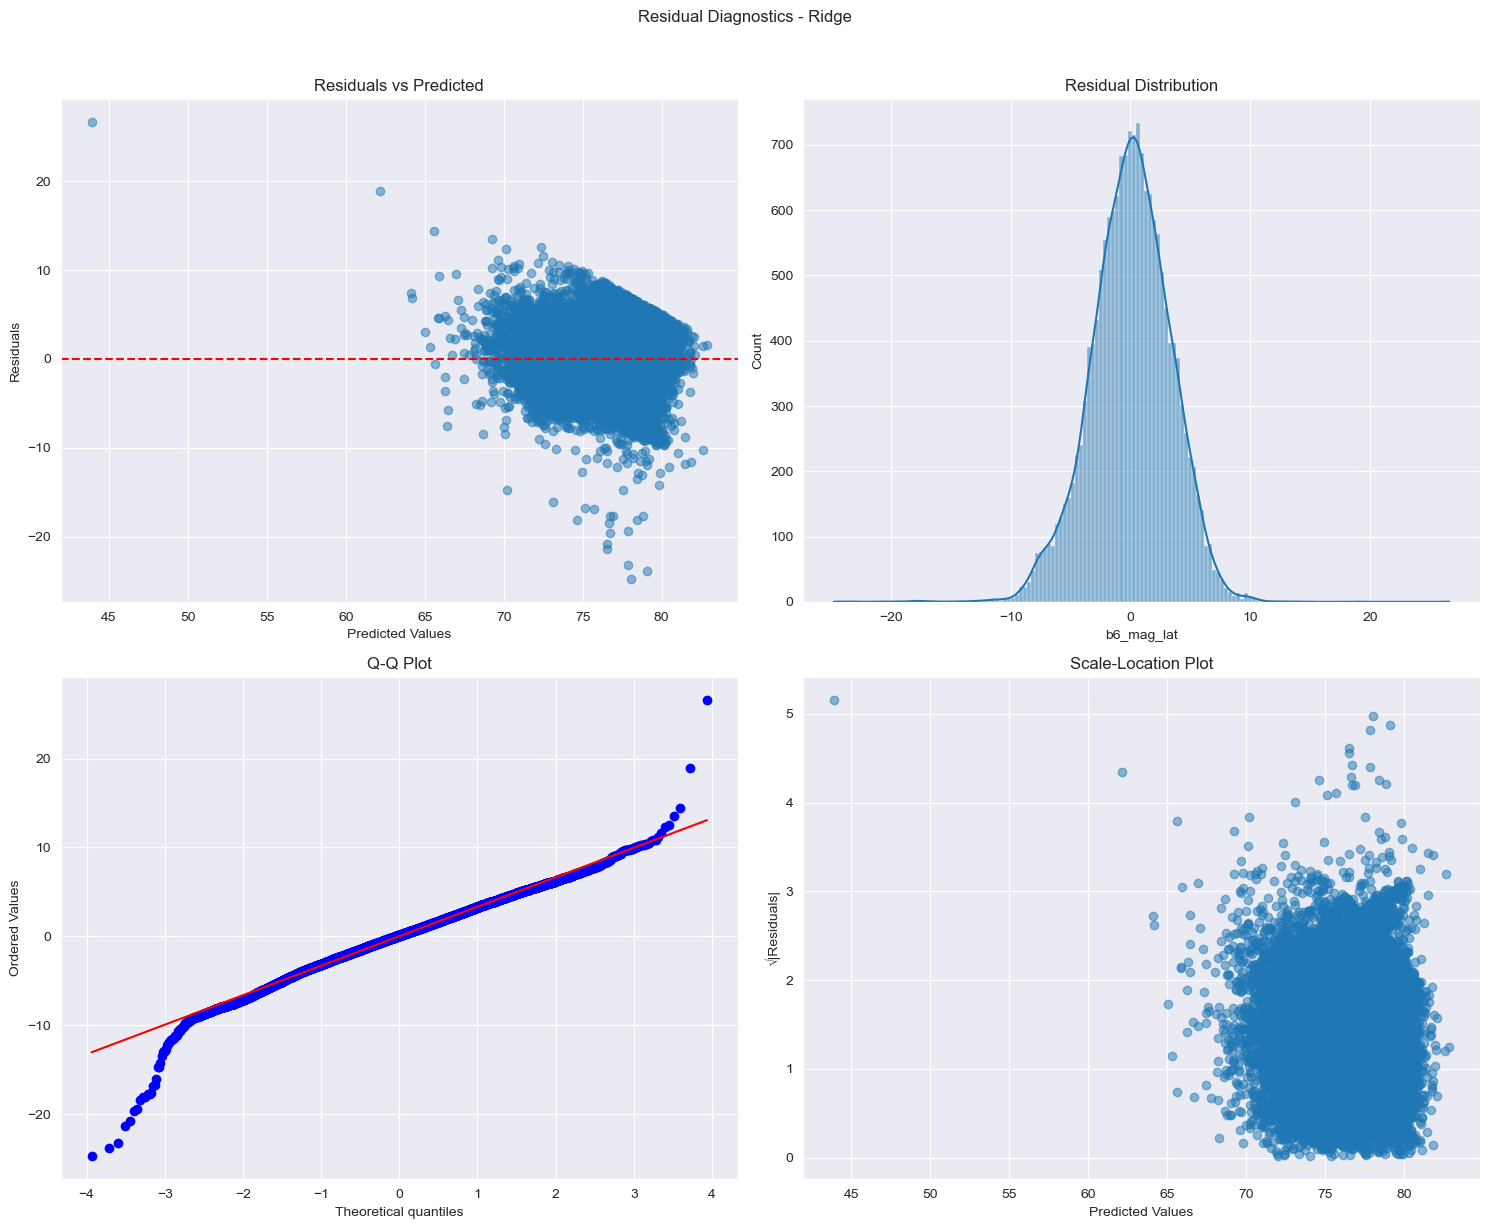

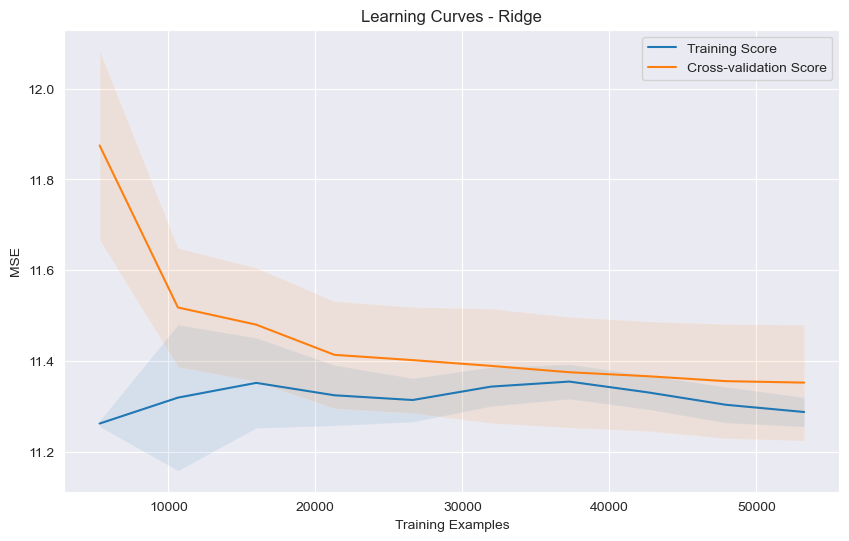


Training Lasso...
Best parameters for Lasso: {'alpha': 0.1, 'selection': 'cyclic'}


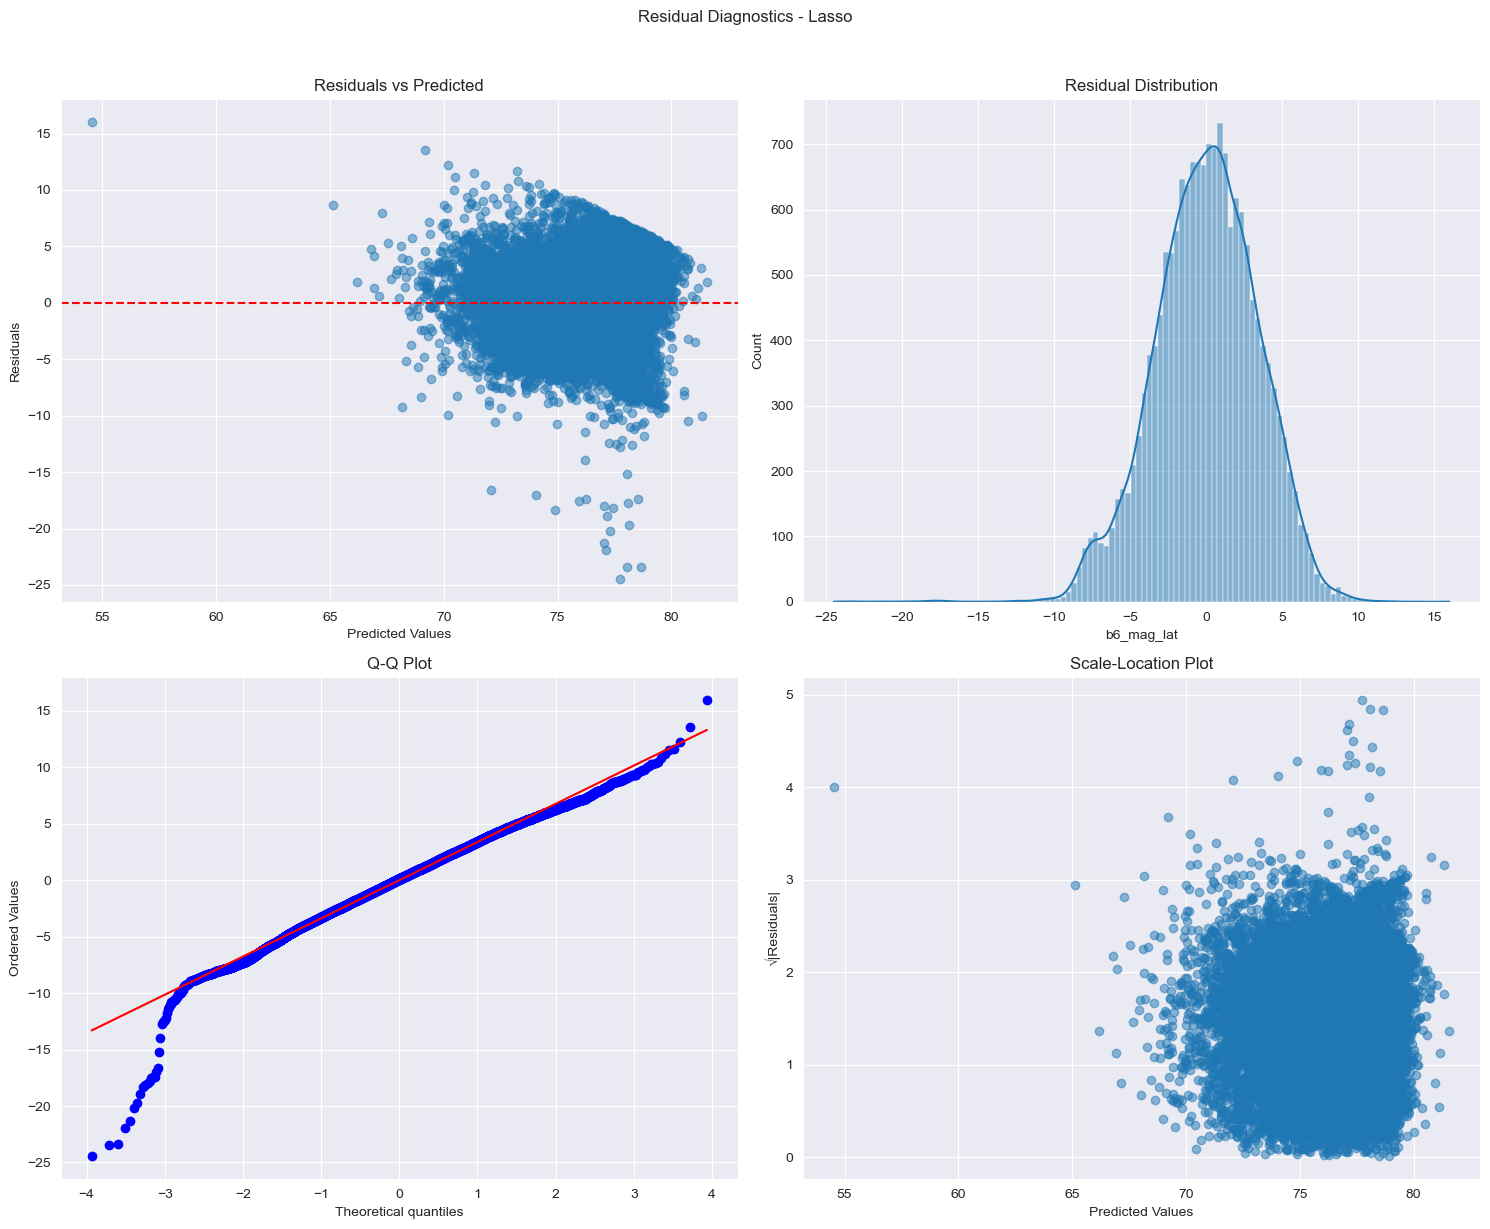

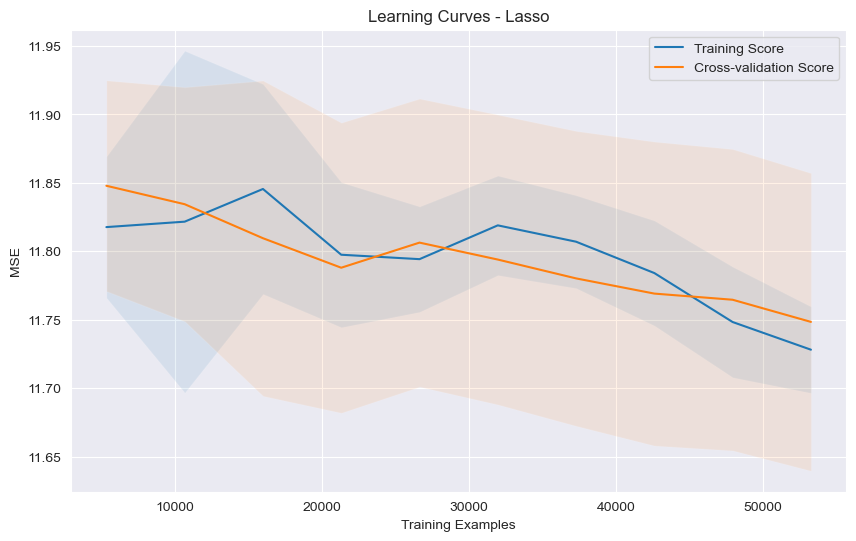


Training ElasticNet...
Best parameters for ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.2}


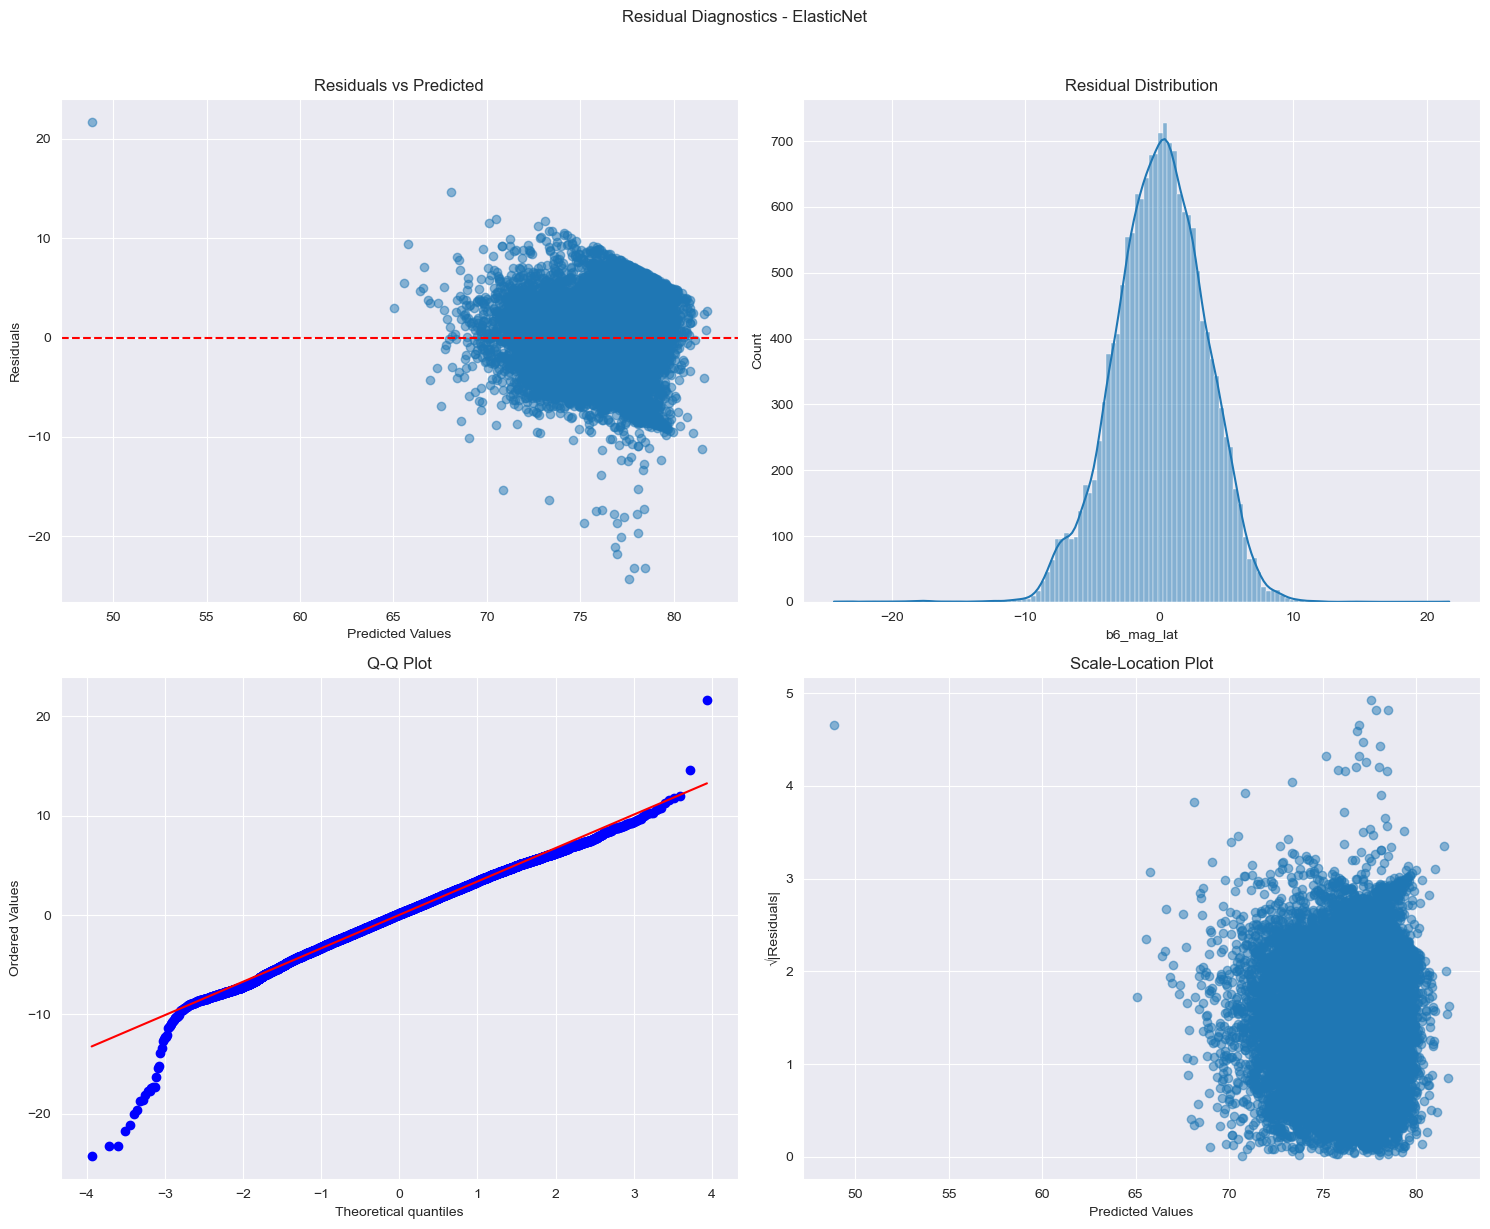

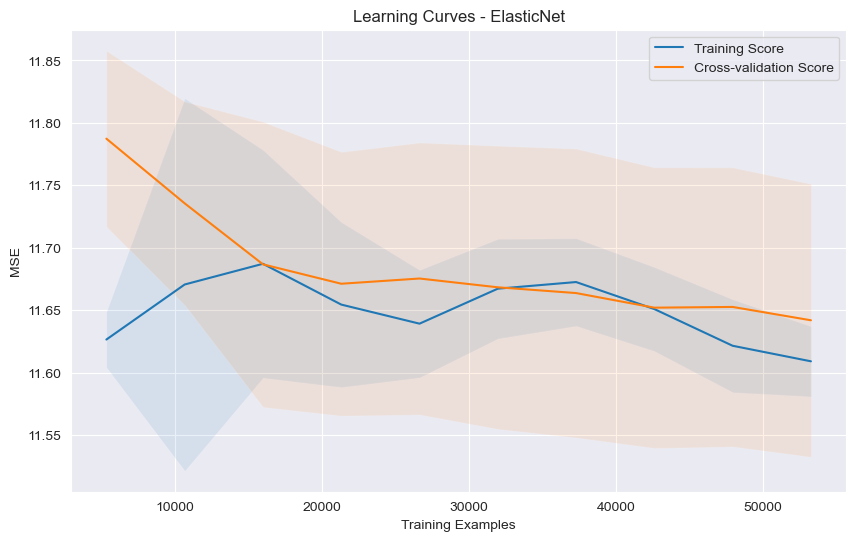


Training RandomForest...


/Users/beastxgamer/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for RandomForest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


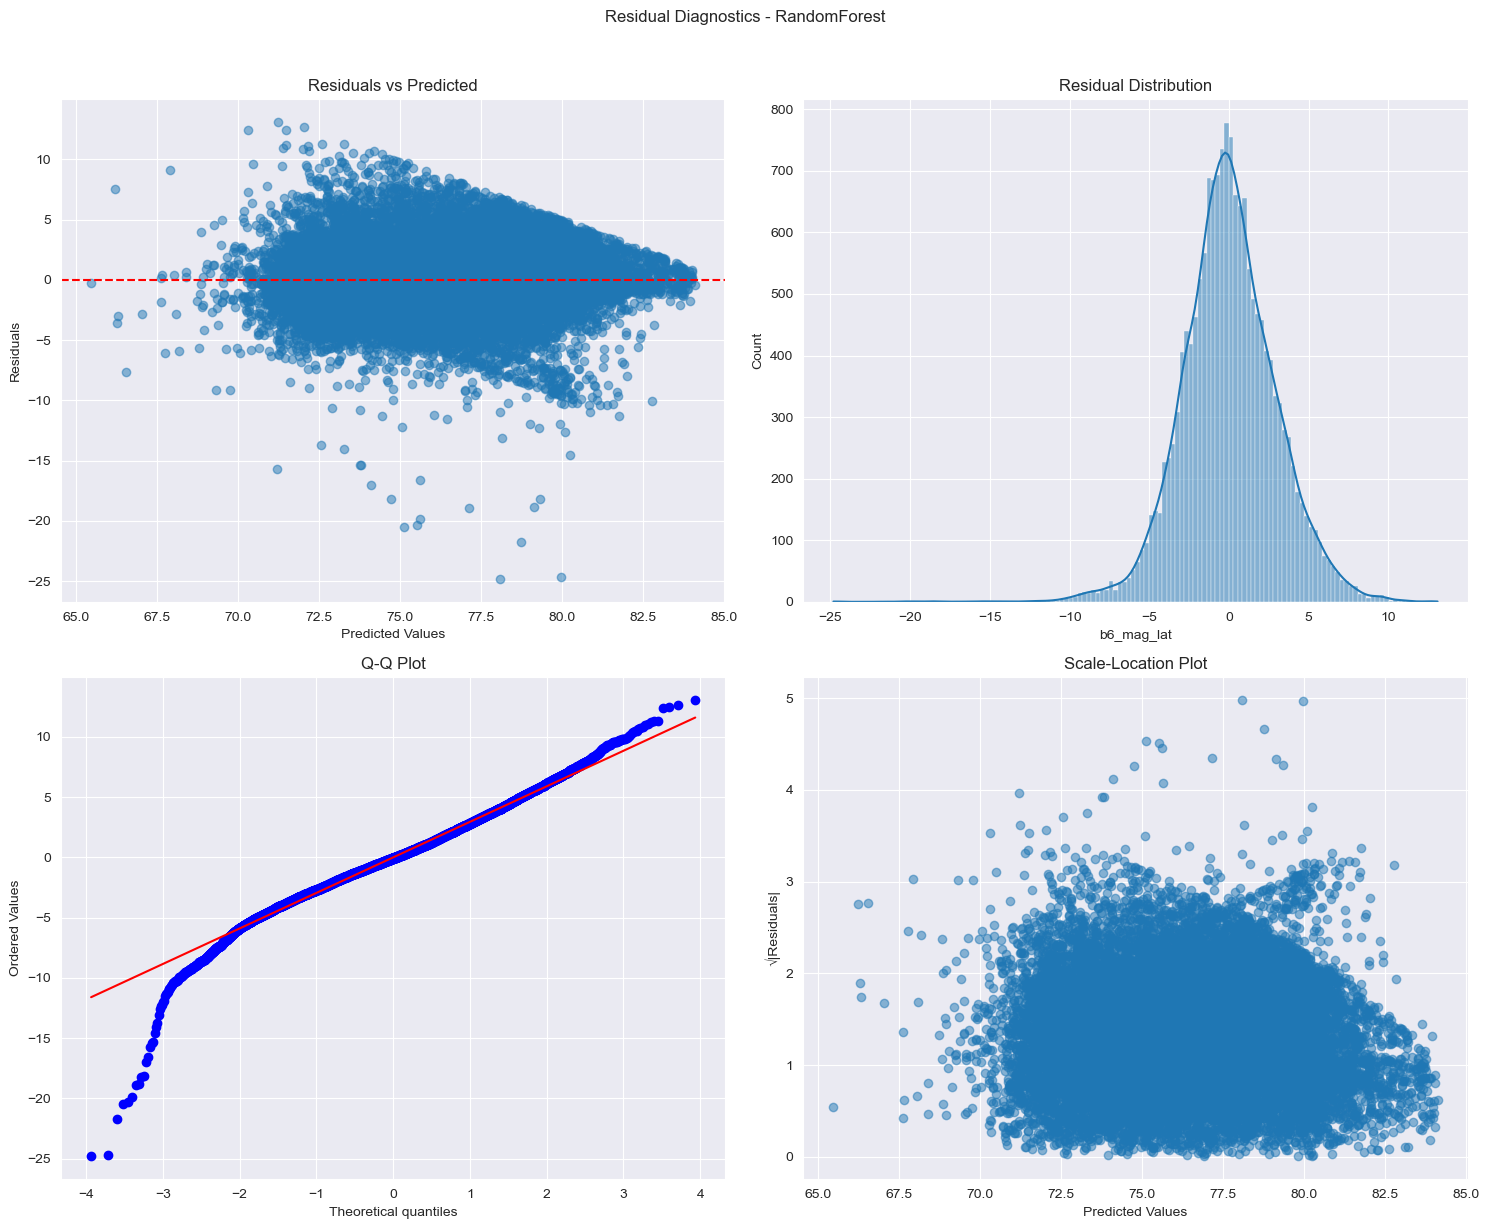

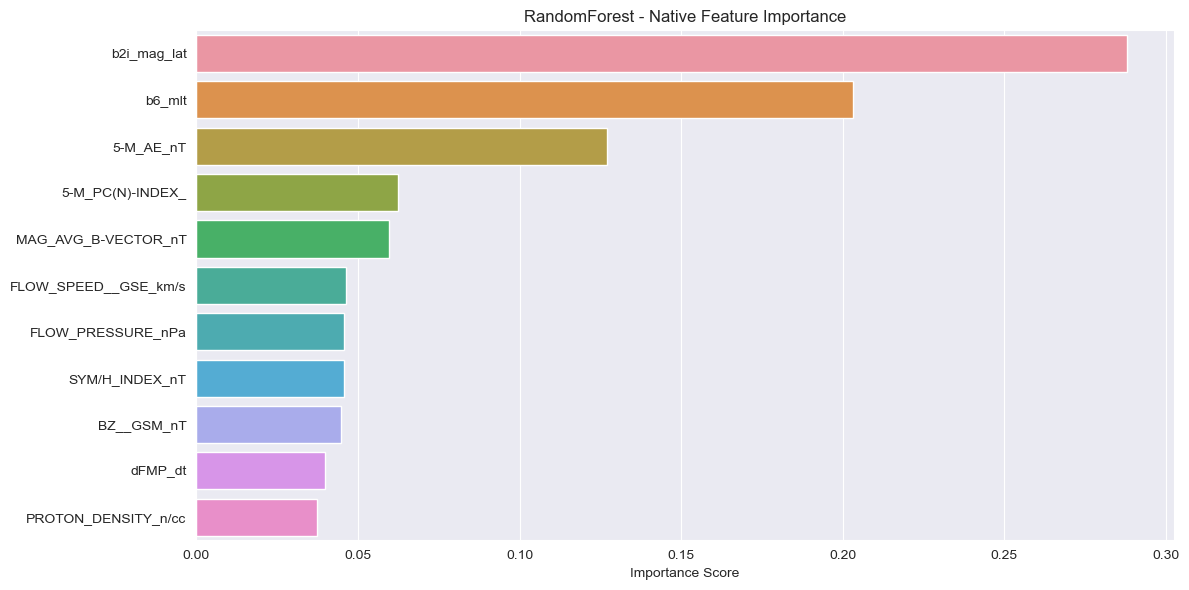

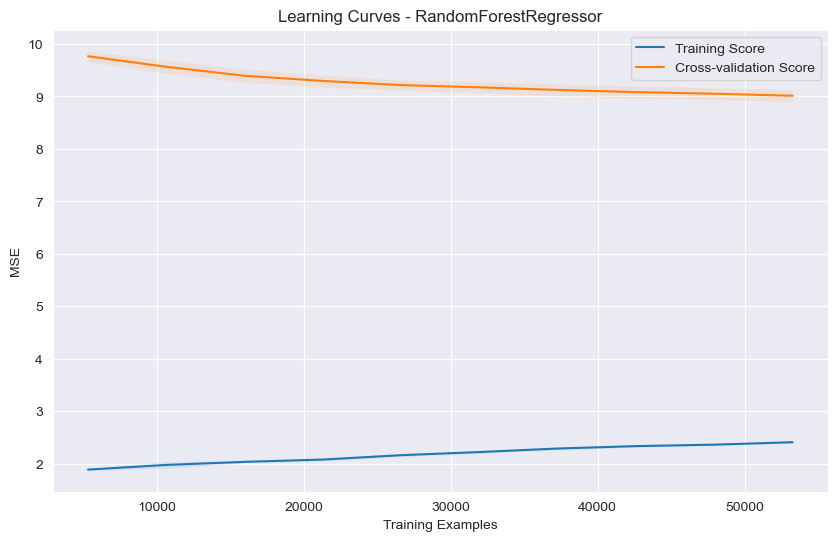

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load data
nightside_df = pd.read_parquet('data/5minData.parquet')
nightside_df = nightside_df[[
    'b6_date', 'b6_mag_lat', 'b6_mlt', 'b2i_mag_lat', 
    'MAG_AVG_B-VECTOR_nT', 'BZ__GSM_nT', 'FLOW_PRESSURE_nPa',
    'FLOW_SPEED__GSE_km/s', '5-M_AE_nT', 'SYM/H_INDEX_nT',
    '5-M_PC(N)-INDEX_', 'PROTON_DENSITY_n/cc', 'dFMP_dt'
]]

dayside_df = pd.read_parquet('data/Dayside.parquet')

# Create hemisphere-specific dataframes
nightsideN_df = nightside_df[
    (nightside_df['b6_mag_lat'] > 50) & 
    (nightside_df['b6_mag_lat'] < 85)
].copy().dropna()

nightsideS_df = nightside_df[
    (nightside_df['b6_mag_lat'] < -50) & 
    (nightside_df['b6_mag_lat'] > -85)
].copy().dropna()

daysideN_df = dayside_df[
    (dayside_df['OCB_mlat'] > 50) & 
    (dayside_df['OCB_mlat'] < 85)
].copy().dropna()

daysideS_df = dayside_df[
    (dayside_df['OCB_mlat'] < -50) & 
    (dayside_df['OCB_mlat'] > -85)
].copy().dropna()

# Define features and target for regression
features_nightside = [
    'b6_mlt', 'b2i_mag_lat', 'MAG_AVG_B-VECTOR_nT',
    'BZ__GSM_nT', 'FLOW_PRESSURE_nPa', 'FLOW_SPEED__GSE_km/s', 
    '5-M_AE_nT', 'SYM/H_INDEX_nT', '5-M_PC(N)-INDEX_', 
    'PROTON_DENSITY_n/cc', 'dFMP_dt'
]
target_nightside = 'b6_mag_lat'

def analyze_hemispheres(north_df, south_df, features, target, hemisphere_label):
    """Analyze both hemispheres using regression models"""
    print(f"\nAnalyzing {hemisphere_label} Hemisphere Data...")
    
    # Analyze feature correlations
    print("\nAnalyzing feature correlations...")
    analyze_feature_correlations(north_df, features, target)
    
    # Train models for northern hemisphere
    print(f"\nTraining {hemisphere_label} Northern Hemisphere Models...")
    north_results, north_models = train_regression_models(
        north_df, features, target
    )
    print(f"\n{hemisphere_label} Northern Hemisphere Results:")
    print(north_results)
    
    # Train models for southern hemisphere
    print(f"\nTraining {hemisphere_label} Southern Hemisphere Models...")
    south_results, south_models = train_regression_models(
        south_df, features, target
    )
    print(f"\n{hemisphere_label} Southern Hemisphere Results:")
    print(south_results)
    
    # Generate ensemble predictions with uncertainty
    X_north_test = north_df[features].iloc[-100:]  # Last 100 samples for testing
    X_south_test = south_df[features].iloc[-100:]
    
    print("\nGenerating predictions with uncertainty...")
    
    # Northern hemisphere predictions
    north_mean, north_lower, north_upper = predict_with_uncertainty(
        north_models, X_north_test
    )
    
    # Southern hemisphere predictions
    south_mean, south_lower, south_upper = predict_with_uncertainty(
        south_models, X_south_test
    )
    
    # Plot predictions with uncertainty
    plt.figure(figsize=(15, 6))
    
    # Northern hemisphere
    plt.subplot(1, 2, 1)
    plt.plot(north_mean, label='Mean Prediction')
    plt.fill_between(
        range(len(north_mean)), 
        north_lower, north_upper,
        alpha=0.2, 
        label='95% Confidence Interval'
    )
    plt.title(f'{hemisphere_label} Northern Hemisphere Predictions')
    plt.legend()
    
    # Southern hemisphere
    plt.subplot(1, 2, 2)
    plt.plot(south_mean, label='Mean Prediction')
    plt.fill_between(
        range(len(south_mean)), 
        south_lower, south_upper,
        alpha=0.2, 
        label='95% Confidence Interval'
    )
    plt.title(f'{hemisphere_label} Southern Hemisphere Predictions')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return (north_results, north_models, south_results, south_models)

# Analyze nightside data
print("Analyzing Nightside Data...")
nightside_results = analyze_hemispheres(
    nightsideN_df,
    nightsideS_df,
    features_nightside,
    target_nightside,
    'Nightside'
)

# Define features and target for dayside analysis
features_dayside = ['OCB_mlt', 'TIMESHIFT_seconds',
       'MAG_AVG_B-VECTOR_nT', 'BX__GSE_nT', 'BY__GSM_nT', 'BZ__GSM_nT',
       'FLOW_SPEED__GSE_km/s', 'VX_VELOCITY__GSE_km/s',
       'VY_VELOCITY__GSE_km/s', 'VZ_VELOCITY__GSE_km/s', 'PROTON_DENSITY_n/cc',
       'FLOW_PRESSURE_nPa', '5-M_AE_nT', '5-M_AL-INDEX_nT', 'SYM/H_INDEX_nT',
       '5-M_PC(N)-INDEX_', 'BT', 'qc', 'sin_term', 'dFMP_dt']
target_dayside = 'OCB_mlat'

# Analyze dayside data
print("\nAnalyzing Dayside Data...")
dayside_results = analyze_hemispheres(
    daysideN_df,
    daysideS_df,
    features_dayside,
    target_dayside,
    'Dayside'
)

# Compare hemispheric differences
def compare_hemispheres(north_results, south_results, hemisphere_label):
    """Compare model performance between hemispheres"""
    metrics = ['RMSE', 'MAE', 'R2']
    
    plt.figure(figsize=(15, 5))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        
        # Plot northern hemisphere results
        plt.bar(
            np.arange(len(north_results)) - 0.2,
            north_results[metric],
            width=0.4,
            label='Northern Hemisphere'
        )
        
        # Plot southern hemisphere results
        plt.bar(
            np.arange(len(south_results)) + 0.2,
            south_results[metric],
            width=0.4,
            label='Southern Hemisphere'
        )
        
        plt.title(f'{metric} Comparison - {hemisphere_label}')
        plt.xticks(range(len(north_results)), north_results['Model'], rotation=45)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Compare hemispheric differences
print("\nComparing Hemispheric Differences...")
compare_hemispheres(
    nightside_results[0], 
    nightside_results[2], 
    'Nightside'
)
compare_hemispheres(
    dayside_results[0], 
    dayside_results[2], 
    'Dayside'
)

# Additional analysis steps
def analyze_temporal_patterns(df, features, target, models):
    """Analyze temporal patterns in predictions"""
    if 'b6_date' in df.columns:
        df['hour'] = pd.to_datetime(df['b6_date']).dt.hour
        
        # Group by hour and analyze prediction errors
        hourly_errors = []
        
        for hour in range(24):
            hour_data = df[df['hour'] == hour]
            if len(hour_data) > 0:
                X = hour_data[features]
                y = hour_data[target]
                
                # Get predictions from each model
                predictions = []
                for model in models.values():
                    if isinstance(model, tf.keras.Sequential):
                        pred = model.predict(X).flatten()
                    else:
                        pred = model.predict(X)
                    predictions.append(pred)
                
                # Calculate mean prediction
                mean_pred = np.mean(predictions, axis=0)
                
                # Calculate error metrics
                mse = mean_squared_error(y, mean_pred)
                mae = mean_absolute_error(y, mean_pred)
                
                hourly_errors.append({
                    'hour': hour,
                    'MSE': mse,
                    'MAE': mae,
                    'samples': len(hour_data)
                })
        
        # Plot temporal patterns
        hourly_errors_df = pd.DataFrame(hourly_errors)
        
        plt.figure(figsize=(12, 6))
        plt.plot(hourly_errors_df['hour'], hourly_errors_df['MAE'], 
                marker='o', label='MAE')
        plt.title('Prediction Error by Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Mean Absolute Error')
        plt.grid(True)
        plt.legend()
        plt.show()

# Analyze temporal patterns for each hemisphere
print("\nAnalyzing Temporal Patterns...")
analyze_temporal_patterns(
    nightsideN_df, 
    features_nightside, 
    target_nightside, 
    nightside_results[1]
)
analyze_temporal_patterns(
    nightsideS_df, 
    features_nightside, 
    target_nightside, 
    nightside_results[3]
)